In [1]:
import importlib
import matplotlib.pyplot as mp
import numpy as np

# Define IAM role
#import boto3
import re
import gzip
%matplotlib inline
import datetime

from sklearn.decomposition import PCA

from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

# create a python file with some functions that we'll use for the analysis
#import funcs
# for clustering
from sklearn.cluster import KMeans
# since I'll be updating funcs.py regularly, tell Jupyter to automatically reload before executing a command 
%load_ext autoreload
%autoreload 2


# to make matplotlib plots appear inline
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
def get_data(filename, comma):
    
    if comma:
        df = pd.read_csv(filename)
    else:
        df = pd.read_csv(filename, sep=';')
    return df

In [4]:
bagsdf = get_data('testdata.csv', True)


In [5]:
bagsdf.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
bagsdf.columns

Index(['MinLoggedUTC', 'MaxExternalBookingID', 'PaxType', 'ChannelID',
       'RoleName', 'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TripReturnTravelDate', 'TripFirstTravelDate', 'SegmentFirstTravelDate',
       'TotalFare', 'JourneySalesDate', 'AgeOfPassengersArray',
       'FirstPaxProgramLevel', 'TreatmentProductSequence', 'TreatmentRanked',
       'TreatmentIDBook', 'QuantityBooked', 'FinalStage', 'ProductID',
       'ProductName', 'Amount', 'OriginalPrice', 'Role_Type', 'Price_Type'],
      dtype='object')

# Data Prep

In [7]:
bagsdf.shape

(10000, 31)

In [8]:
bagsdf.isnull().sum()

MinLoggedUTC                         0
MaxExternalBookingID                 0
PaxType                              0
ChannelID                            0
RoleName                             0
TripOriginLocationCode               0
TripDestinationLocationCode          0
NumberOfPassengers                   0
FareClass                            0
TripType                             0
TreatmentRank                        0
SegmentOriginLocationCode            0
SegmentDestinationLocationCode       0
TripReturnTravelDate              3898
TripFirstTravelDate                  0
SegmentFirstTravelDate               0
TotalFare                            0
JourneySalesDate                   193
AgeOfPassengersArray              7239
FirstPaxProgramLevel              7971
TreatmentProductSequence             0
TreatmentRanked                      0
TreatmentIDBook                      0
QuantityBooked                       0
FinalStage                           0
ProductID                

In [9]:
cols=list(bagsdf.columns)
#cols

with null values:
- TripReturnTravelDate
- JourneySalesDate
- AgeofPssengersArray
- FirstPaxProgramLevel

- Drop the columns JourneySalesDate, AgeofPssengersArray & FirstPaxProgramLevel because of large amounts of null values(more than half of the rows are nul) and they arent useful
- However the date the prodcut was sold and the trip return date may be helpful
- From comparing MinLoggedUTC to JourneySalesDate they seem to be the same data

In [10]:
bagsdf.drop(["AgeOfPassengersArray","FirstPaxProgramLevel", 'MinLoggedUTC'], axis=1, inplace=True)

In [11]:
#U for Unknown
#bagsdf.fillna('U', inplace=True)

In [12]:
def changeDate(col, delim):
    y=col.strip("Date")
    if(delim == '-'):
        bagsdf[y+"Year"]=[int(x.split(delim)[0]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Month"]=[int(x.split(delim)[1]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Day"]=[int(x.split(delim)[2][0:2]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
    else:
        bagsdf[y+"Year"]=[int(x.split(delim)[2][0:4]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Month"]=[int(x.split(delim)[0]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Day"]=[int(x.split(delim)[1]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
    bagsdf.pop(col)

In [13]:
bagsdf.columns

Index(['MaxExternalBookingID', 'PaxType', 'ChannelID', 'RoleName',
       'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TripReturnTravelDate', 'TripFirstTravelDate', 'SegmentFirstTravelDate',
       'TotalFare', 'JourneySalesDate', 'TreatmentProductSequence',
       'TreatmentRanked', 'TreatmentIDBook', 'QuantityBooked', 'FinalStage',
       'ProductID', 'ProductName', 'Amount', 'OriginalPrice', 'Role_Type',
       'Price_Type'],
      dtype='object')

In [14]:
changeDate("JourneySalesDate", '-')

In [15]:
changeDate('TripFirstTravelDate', '/')

In [16]:
changeDate('SegmentFirstTravelDate', '/')

In [17]:
changeDate('TripReturnTravelDate', '/')

In [18]:
bagsdf.columns

Index(['MaxExternalBookingID', 'PaxType', 'ChannelID', 'RoleName',
       'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TotalFare', 'TreatmentProductSequence', 'TreatmentRanked',
       'TreatmentIDBook', 'QuantityBooked', 'FinalStage', 'ProductID',
       'ProductName', 'Amount', 'OriginalPrice', 'Role_Type', 'Price_Type',
       'JourneySalesYear', 'JourneySalesMonth', 'JourneySalesDay',
       'TripFirstTravelYear', 'TripFirstTravelMonth', 'TripFirstTravelDay',
       'SegmentFirstTravelYear', 'SegmentFirstTravelMonth',
       'SegmentFirstTravelDay', 'TripReturnTravelYear',
       'TripReturnTravelMonth', 'TripReturnTravelDay'],
      dtype='object')

In [19]:
bagsdf.TreatmentIDBook.value_counts() #all values are unique => not useful

0            8700
611263758       1
611605609       1
612138109       1
611498675       1
612496516       1
612899985       1
611947688       1
612097193       1
611140786       1
612787382       1
612953279       1
612960277       1
612834497       1
611327177       1
611335373       1
611661036       1
611974381       1
611704065       1
611413079       1
612035663       1
611087436       1
612307944       1
611832720       1
611527583       1
611392417       1
611926970       1
611599306       1
612785121       1
611763170       1
             ... 
611981982       1
611404372       1
611889827       1
611498674       1
613640888       1
611879612       1
612329947       1
611670734       1
611404508       1
611686998       1
611250755       1
611256700       1
611520991       1
611942805       1
612346264       1
612553119       1
612442537       1
611348915       1
611910077       1
611725779       1
612618735       1
612688441       1
612538878       1
611850774       1
612831767 

In [20]:
bagsdf.drop("TreatmentIDBook", axis=1, inplace=True)

In [21]:
#Cols ProductName and Product ID give the same info
bagsdf[['ProductName', 'ProductID']].head()

,ProductName,ProductID
0,BAG1,78
1,COB1,84
2,BAG1,78
3,COB1,84
4,BAG1,78


In [22]:
bagsdf.drop("ProductName", axis=1, inplace=True)

In [23]:
bagsdf.JourneySalesDay.value_counts()

1     9371
0      193
10      44
14      40
21      32
18      28
11      28
20      26
26      20
27      20
13      20
16      16
6       16
17      14
15      14
5       12
8       12
24      12
7       12
23      12
28      12
25       8
9        8
19       8
12       8
30       8
29       4
22       2
Name: JourneySalesDay, dtype: int64

In [24]:
bagsdf.ProductID.head()

0    78
1    84
2    78
3    84
4    78
Name: ProductID, dtype: int64

In [25]:
df=pd.get_dummies(bagsdf, drop_first=False)

In [26]:
df['QuantityBooked'].value_counts()

0    8700
1    1044
2     198
3      30
4      18
7       4
6       4
5       2
Name: QuantityBooked, dtype: int64

In [27]:
df.loc[df['QuantityBooked']>=1,'Booked']=1

In [28]:
df["Booked"] = [1 if i>=1 else 0 for i in df['QuantityBooked']>=1]

# Visualisation

In [29]:
import matplotlib.pyplot as plt

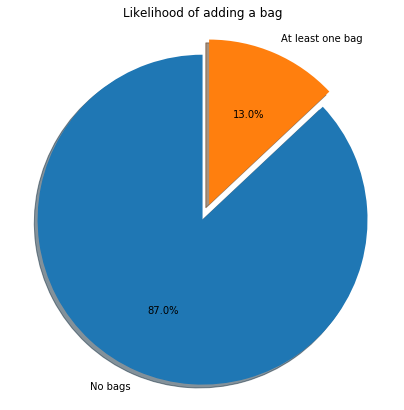

In [30]:
fig,ax=plt.subplots(figsize=(7,7))
s2=dict(df.Booked.value_counts())
vals=list(s2.values())
labels=['No bags', 'At least one bag']
explode=(0,0.1)
#fig1, ax1 = plt.subplots()
ax.pie(vals, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Likelihood of adding a bag')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [31]:
bagsbyMonth= bagsdf.groupby(['TripFirstTravelMonth', 'QuantityBooked']).size().reset_index(name='counts')

In [32]:
month={}

for i in range(1,13):
    sum=0
    for ind in bagsbyMonth.index:
        if (bagsbyMonth.TripFirstTravelMonth[ind]==i):
            sum = sum + bagsbyMonth.QuantityBooked[ind]*bagsbyMonth.counts[ind]
        month[i]=sum
    

C:\Users\oyino\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


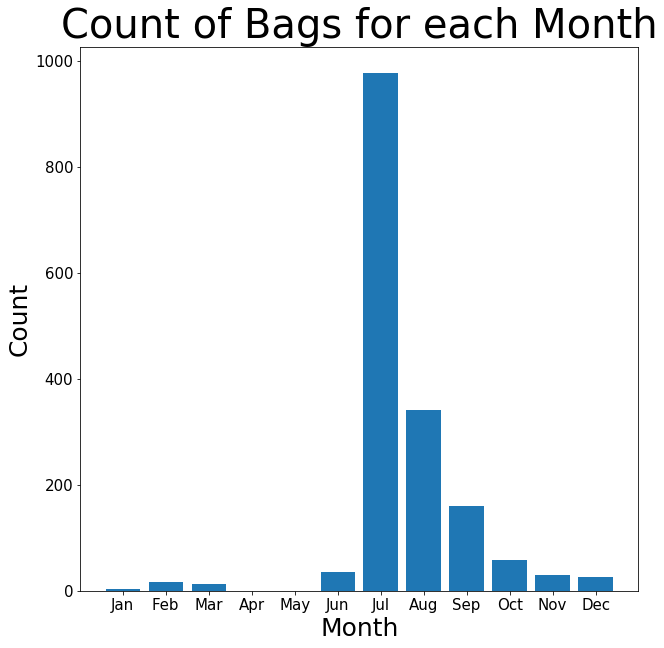

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(month.keys(), month.values())
time=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(time)
time=range(1,13,1)
ax.set_xticks(time)
ax.tick_params(labelsize=15)
ax.set_xlabel("Month", fontsize=25)
ax.set_ylabel("Count", fontsize=25)
ax.set_title("Count of Bags for each Month", fontsize=40)

fig.show()
#to do
#color-code bars by season
#subscripts #no of bags

# Prediction

In [34]:
y=df.pop('Booked').values
df.pop('QuantityBooked')
X=df.values


In [35]:
X.shape
y.shape

(10000,)

In [36]:
from collections import Counter

In [37]:
print("Minority class : %0.2f" % (Counter(y)[1]/len(y)))
#Could be bias towards majority class => no bags booked

Minority class : 0.13


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [40]:
print("Minority in training set : %d" % (Counter(y_train)[1]))
print("Minority in test set : %d" % (Counter(y_test)[1]))


Minority in training set : 1060
Minority in test set : 240


In [41]:
models= {}
models['dtree'] =  DecisionTreeClassifier(criterion='entropy')
models['logistic'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=0)
models['gbc']=GradientBoostingClassifier()


In [42]:
#Binary classifications w/ logistic regression predcit if bought or not
#clf = LogisticRegression(random_state=0, max_iter=10000)


In [43]:
from functools import reduce

In [ ]:
reps=100
for model in models:
    xv=[]
    for i in range(reps):
        kf = KFold(n_splits=10, shuffle = True) 
        scores = cross_val_score(models[model], X_train, y_train, cv=kf)
        xv.append(scores.mean())
    avg_acc=reduce(lambda a, b: a + b, xv) / len(xv)
    print("{:22} Avg. Accuracy: {:.2f}".format(type(models[model]).__name__,avg_acc)) 
            

DecisionTreeClassifier Avg. Accuracy: 1.00


- Pick the model with the best accuracy score then do feature selection on that model
- Let's go with logistic regression

# Feature Selection w/ RFE

In [ ]:
#Ridge/LASSO/Elastic Net

In [ ]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.feature_selection import RFE

In [ ]:
num_feats=100

In [ ]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0, max_iter=10000), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = df.loc[:,rfe_support].columns.tolist()
#print(str(len(rfe_feature)), 'selected features')
print("Selected Features: %s"% rfe_support_)

In [ ]:
print("Selected Features: %s"% rfe_selector.support_)

In [ ]:
print("Selected Features: %s"% rfe_feature)

In [ ]:
X_train.shape

In [ ]:
X_aft=X_train[:,rfe_selector.support_]

In [ ]:
y_train

In [ ]:
X_aft.shape

In [ ]:
clf=models['logistic']

In [ ]:
xv=[]
for i in range(reps):
    kf = KFold(n_splits=10, shuffle = True) 
    scores = cross_val_score(clf, X_aft, y_train, cv=kf)
    xv.append(scores.mean())
avg_acc=reduce(lambda a, b: a + b, xv) / len(xv)
print("{:22} Avg. Accuracy: {:.2f}".format(type(models['logistic']).__name__,avg_acc)) 
              

In [ ]:
type(X_train)

In [ ]:
len(rfe_feature)

In [ ]:
#list(df.columns)

In [ ]:
#X_train.loc